## Data Cleaning and Visualization

In [2]:
# necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import folium


In [87]:
#open the file
file_path = 'sensor_data_all (1).csv'  
df = pd.read_csv(file_path)
df = pd.DataFrame(df)

In [ ]:

## outlier 
# Create a boxplot to visualize the outliers

numeric_columns = ['pm25', 'pm10', 'so2', 'no', 'o3']
df.boxplot(column= numeric_columns)
plt.show()
# remove the rows with the outliers the is higher than 150. maybe there is a problem with the sensor 
min_value = 150
max_value = -99
mask = ~df[numeric_columns].apply(lambda x: ((x >= min_value) | (x <= max_value)).any(), axis=1)
df_filtered = df[mask]

In [ ]:

## the average values per country
# replace the missing values by the mean 
# if we would consider removing the hole row it would leave us with a very small data set.
#but we can remove the hole row if there are more than two sensor with missing value per country

numeric_columns = ['pm25', 'pm10', 'so2', 'no', 'o3']
df_filtered[numeric_columns] = df_filtered[numeric_columns].applymap(lambda x: np.nan if x < 0 else x)
average_per_country = df_filtered.groupby(['country'])[numeric_columns].mean().reset_index()

mask = average_per_country.iloc[:, 1:].isna().sum(axis=1) > 2
average_cleaned = average_per_country[~mask]

# replace missing value with the mean 
average_cleaned[numeric_columns] = average_cleaned[numeric_columns].fillna(average_cleaned.mean(numeric_only=True))

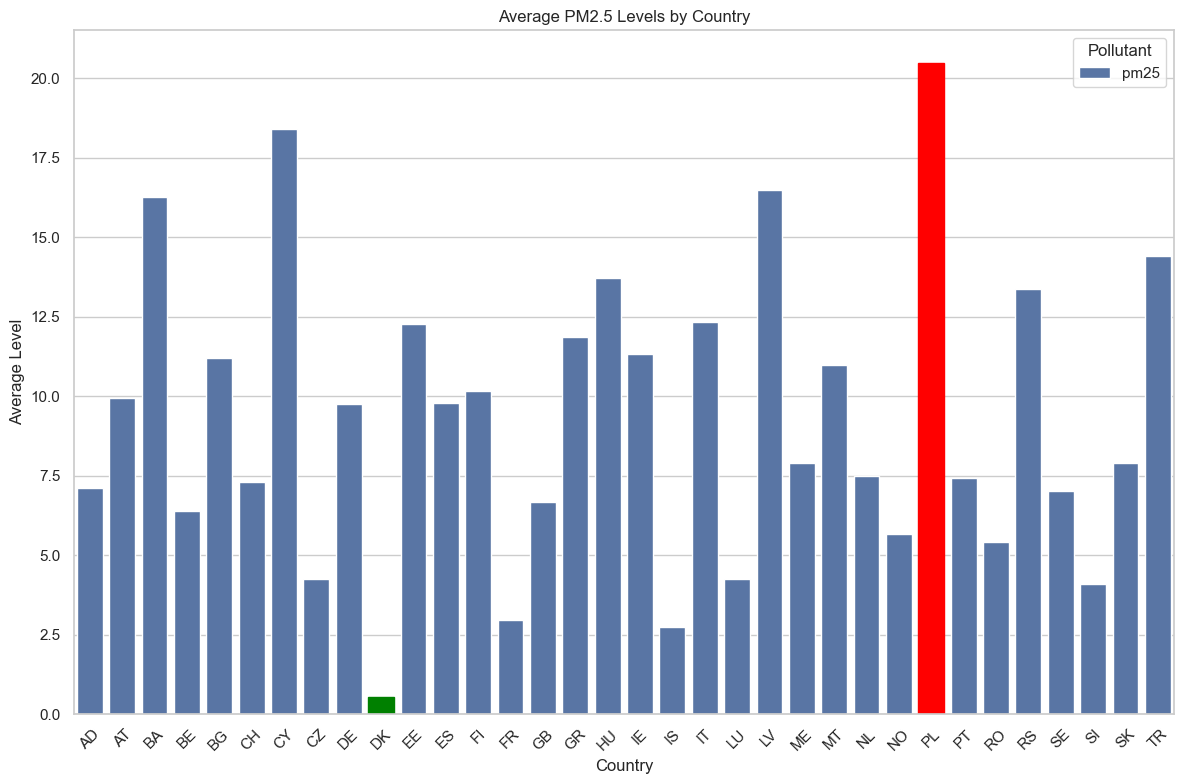

In [106]:
# average_cleaned DataFrame is ready to plot
# plot the average values of pm25 by country

average_melted = average_cleaned.melt(id_vars='country', value_vars="pm25",
var_name='Pollutant', value_name='Average')

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='country', y='Average', hue='Pollutant', data=average_melted)

# Find the lowest and highest value of pm25
for patch in ax.patches:
    height = patch.get_height()
    if height == average_melted['Average'].min():
        patch.set_color('green')
    elif height == average_melted['Average'].max():
        patch.set_color('red')


# Enhance the plot
plt.title('Average PM2.5 Levels by Country')
plt.xlabel('Country')
plt.ylabel('Average Level')
plt.xticks(rotation=45)
plt.legend(title='Pollutant')
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# merging the air quality data with the economics data by country
df_economics = pd.read_csv('world-data-2023.csv')
merged_data = pd.merge(average_cleaned, df_economics, left_on='country', right_on='Abbreviation', how='inner')



merged_data = merged_data.drop(columns=['Abbreviation','Currency-Code','Land Area(Km2)','Armed Forces size',
                                      'Birth Rate', 'Calling Code', 'Capital/Major City',
                                         'CPI', 'CPI Change (%)', 'Currency-Code', 'Fertility Rate',
                                          'Gasoline Price','Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)',
                                            'Infant mortality', 'Largest city', 
                                            'Maternal mortality ratio', 'Minimum wage', 'Official language', 'Out of pocket health expenditure',
                                            'Physicians per thousand','Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate',
                                              'Unemployment rate', 'Urban_population'])

# rearrange the columns order 
new_order = ['Country', 'country', 'pm25', 'pm10', 'so2', 'no', 'o3', 'Density (P/Km2)', 'Agricultural Land( %)', 'Co2-Emissions', 
             'Forested Area (%)', 'GDP', 'Life expectancy', 'Population', 'Latitude', 'Longitude'] 

merged_data = merged_data[new_order]


# add GDP per Capita
merged_data['GDP'] = merged_data['GDP'].replace('[\$,]', '', regex=True).astype(float)
merged_data['Population'] = merged_data['Population'].replace(',', '', regex=True).astype(float)

if 'GDP' in merged_data.columns and 'Population' in merged_data.columns:
    # Add a new column 'GDP per Capita'
    merged_data['GDP per Capita'] = merged_data['GDP'] / merged_data['Population']


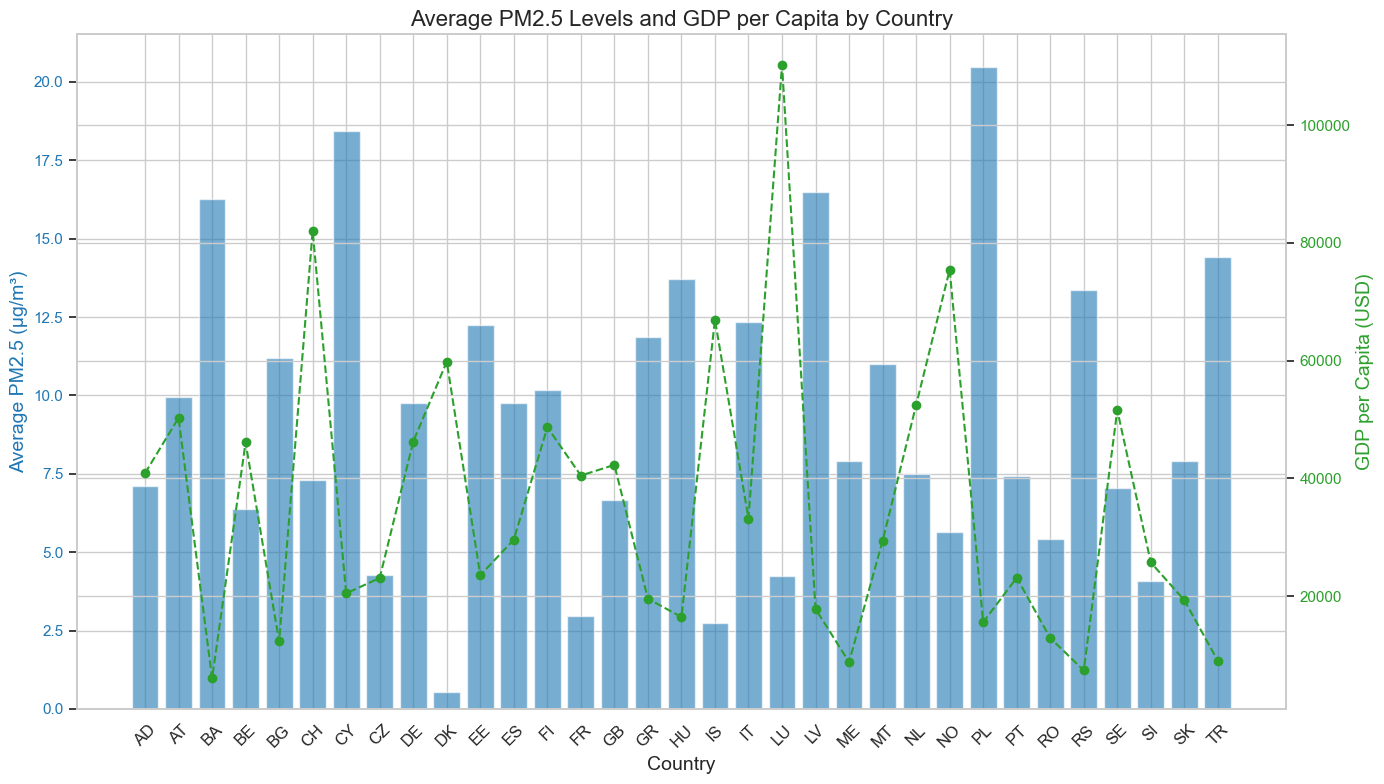

In [126]:
# Plot GDP per Capita and PM25 level

fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for PM2.5
color = 'tab:blue'
ax1.set_xlabel('Country', fontsize=14)
ax1.set_ylabel('Average PM2.5 (µg/m³)', color=color, fontsize=14)
ax1.bar(merged_data['country'], merged_data['pm25'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45, labelsize=12)

# Create a second y-axis for GDP per Capita
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('GDP per Capita (USD)', color=color, fontsize=14)
ax2.plot(merged_data['country'], merged_data['GDP per Capita'], color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Average PM2.5 Levels and GDP per Capita by Country', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()


In [139]:
# Create a base map using the average values per country 

madrid_map = folium.Map(location=[40.416775, -3.703790], zoom_start=4)

eu_data_layer = FeatureGroup(name="EU Data").add_to(madrid_map)
df_data_layer = FeatureGroup(name="Sensor Data").add_to(madrid_map)

# Feature Groups for different data types (uncomment if you want to use these layers)
# economics_layer = FeatureGroup(name="Economics Data").add_to(madrid_map)
#pm25_layer = FeatureGroup(name="PM2.5").add_to(madrid_map)
# pm10_layer = FeatureGroup(name="PM10").add_to(madrid_map)
# so2_layer = FeatureGroup(name="SO2").add_to(madrid_map)
# no_layer = FeatureGroup(name="NO").add_to(madrid_map)
# o3_layer = FeatureGroup(name="O3").add_to(madrid_map)

# Add markers for each location
for index, row in merged_data.iterrows():
    popup_text = (f"<b>Location:</b> {row['Country']}<br>"
                  f"<b>PM2.5:</b> {row['pm25']:.2f} µg/m³<br>"
                  f"<b>PM10:</b> {row['pm10']:.2f} µg/m³<br>"
                  f"<b>SO2:</b> {row['so2']:.2f} µg/m³<br>"
                  f"<b>NO:</b> {row['no']:.2f} µg/m³<br>"
                  f"<b>O3:</b> {row['o3']:.2f} µg/m³<br>"
                  f"<b>Agricultural Land:</b> {row['Agricultural Land( %)']}<br>"
                  f"<b>GDP per Capita:</b> {row['GDP per Capita']:.2f} USD"
                  )
    
    # Determine color based on PM2.5 value
    if pd.isna(row['pm25']):
        continue  # Color for missing values
    elif row['pm25'] < 6:
        color = "green"
    elif 6 <= row['pm25'] < 12:
        color = "lightgreen"
    elif 12 <= row['pm25'] < 20:
        color = "orange"
    else:
        color = "red"

    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=folium.Popup(popup_text, max_width=250),
        tooltip=folium.Tooltip(f"{row['Country']}"),
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(madrid_map)

 

legend_html = '''
    <div style="
        position: fixed; 
        bottom: 10px; left: 10px; width: 160px; height: auto; 
        background-color: white; border:2px solid grey; border-radius: 5px; z-index:9999; font-size:14px;
        box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
        padding: 10px;
        ">
        <b>PM2.5 Levels</b><br>
        <i style="background: green; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> &nbsp; < 6 µg/m³<br>
        <i style="background: lightgreen; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> &nbsp; 6 - 12 µg/m³<br>
        <i style="background: orange; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> &nbsp; 12 - 20 µg/m³<br>
        <i style="background: red; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> &nbsp; ≥ 20 µg/m³<br>

    </div>
'''

madrid_map.get_root().html.add_child(folium.Element(legend_html))

#Add Layer Control (uncomment if using layers)
#LayerControl().add_to(madrid_map)

# Display the map
madrid_map


The orginal map

In [3]:
from folium import FeatureGroup, LayerControl

file_path = 'sensor_data_all (1).csv'  # Replace with the path to your file
df = pd.read_csv(file_path)
# Create a base map
madrid_map = folium.Map(location=[40.416775, -3.703790], zoom_start=4)  # Centered on Madrid


#economics_layer = FeatureGroup(name="Economics Data").add_to(madrid_map)
#pm25_layer = FeatureGroup(name="PM2.5").add_to(madrid_map)
#pm10_layer = FeatureGroup(name="PM10").add_to(madrid_map)
#so2_layer = FeatureGroup(name="SO2").add_to(madrid_map)
#no_layer = FeatureGroup(name="NO").add_to(madrid_map)
#o3_layer = FeatureGroup(name="O3").add_to(madrid_map)


# Add markers for each location
for index, row in df.iterrows():
    popup_text = (f"<b>Location:</b> {row['location']}<br>"
                  f"<b>PM2.5:</b> {row['pm25']} µg/m³<br>"
                  f"<b>PM10:</b> {row['pm10']} µg/m³<br>"
                  f"<b>SO2:</b> {row['so2']} µg/m³<br>"
                  f"<b>NO:</b> {row['no']} µg/m³<br>"
                  f"<b>O3:</b> {row['o3']} µg/m³<br>")
    

    if pd.isna(row['pm25']):
         color = "yellow"

    elif row['pm25'] < 6:
         color = "green"
    elif 12 <= row['pm25'] <= 14:
        color = "lightgreen"
    else:
        color = "red"

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=folium.Popup(popup_text, max_width=250),
        tooltip=folium.Tooltip(f"{row['location']}"), 
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(madrid_map)    


# Add the fixed legend to the map

#LayerControl().add_to(madrid_map)
# Display the map
madrid_map